# Deep Reinforcement Learning - Project 2: Continuous Control

The goal of this project is to teach an autonomous agent with a double-jointed arm to keep its hand in a moving target location for as long as possible. 

---

In [1]:
### Imports

# General
import numpy as np
from scipy.signal import savgol_filter
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

# Unity Environment
from unityagents import UnityEnvironment

## 1. Examine Problem Setup

Check out the specifics of the Reacher environment.

In [2]:
env = UnityEnvironment(file_name='./Reacher-2.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# Create agent interface
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
### Examine problem setup

# Reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# Check number of agent workers
n_workers = len(env_info.agents)
print("Agent:")
print("=======")
print("Number of agent workers:", n_workers)

# Check observation space
state_dim = brain.vector_observation_space_size

print("\nObservation Space:")
print("==================")
print("Type:   ", brain.vector_observation_space_type)
print("Size:   ", state_dim)
print("Example state vector:\n", env_info.vector_observations[0])

# Check action space
action_dim = brain.vector_action_space_size

print("\nAction Space:")
print("=============")
print("Type:   ", brain.vector_action_space_type)
print("Size:   ", action_dim)
print("Actions: joint torques [-1,1]")

# Rewards
print("\nReward Function:")
print("================")
print("Move around:     0")
print("Hand in target: +0.1 / timestep")

Agent:
Number of agent workers: 20

Observation Space:
Type:    continuous
Size:    33
Example state vector:
 [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]

Action Space:
Type:    continuous
Size:    4
Actions: joint torques [-1,1]

Reward Function:
Move around:     0
Hand in target: +0.1 / timestep


---

## 2. Define Agent

Build a double-jointed arm agent! 

In this case, the Double-Jointed Arm Controller is defined as a policy-based agent.  
Let's try the PPO algorithm. 

In [5]:
class PPOActorCriticNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_layer_sizes=[64, 64], seed=0):
        """Initialize network.
        
        Parameters
        ==========
            state_dim          : dimension of state vector            : (int) 
            action_dim         : dimension of action vector           : (int) 
            hidden_layer_sizes : number of nodes in each hidden layer : (list[int]) 
            seed               : random seed                          : (int) 
        """
        
        super().__init__()
        _ = torch.manual_seed(seed)
        
        ### Define neural network architecture
        # The PPO Actor/Critic consists of two NNs sharing weights
        # Only the "heads" (output layers) differ
    
        ### Network body
        
        # Add layer mapping input (state) to first hidden layer
        self.nn_layers = nn.ModuleList([nn.Linear(state_dim, hidden_layer_sizes[0])])
        
        # Add a variable number of additional hidden layers
        layer_sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.nn_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        ### Network heads
        
        ### Actor: 
        # Actions are modelled as a (multivariate) Gaussian to allow for some exploring
        # Thus, output is taken as the mean vector of the distribution
        # Corresponding standard deviations are separately added as an nn.Parameter
        # which includes them in the learnable parameter set
        self.actor_head = nn.Linear(hidden_layer_sizes[-1], action_dim)
        self.action_stds = nn.Parameter(torch.zeros(action_dim))
        
        ### Critic:
        # The critic estimates the value function
        self.critic_head = nn.Linear(hidden_layer_sizes[-1], 1)

        
    def forward(self, current_states, actions=None):
        """Do a forward pass through the network.
        
        Parameters
        ==========
            current_states : input vector, i.e. current environment states : (numpy.ndarray[state_dim])
        """
        
        x = torch.Tensor(current_states)
        
        # Forward states through each layer in the network body, using ReLU activation
        for layer in self.nn_layers:
            x = F.relu(layer(x))
                    
        ### Actor: 
        # Form the multivariate Gaussian for actions
        # Actions [-1, 1], so pass mean vector through tanh
        # Pass stds throuigh softplus: f(x) = ln(1+ex) to make sure it is not negative
        means = F.tanh(self.actor_head(x))
        dists = torch.distributions.Normal(means, F.softplus(self.action_stds))
        
        # Sample actions to take (unless supplied)
        if actions is None:
            actions = dists.sample()

        # Calculate the log probabilities of actions
        action_log_probs = dists.log_prob(actions).sum(-1).unsqueeze(-1)
        
        # Calculate dist entropies (used in loss function to encourage exploration)
        dist_entropies = dists.entropy().sum(-1).unsqueeze(-1)

        ### Critic: 
        # Outputs an estimation of the values of the current states
        # (i.e. no activation fcn)
        values = self.critic_head(x)
                
        return values, actions, action_log_probs, dist_entropies

The PPO agent code is a modification of the excellent implementation of DeepRL by Shangtong Zhang:   
https://github.com/ShangtongZhang/DeepRL

In [6]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

class PPOAgent:
    
    def __init__(self, state_dim, action_dim, n_workers, hyperparameters, seed=0):
        """Initialize PPO Agent.
        
        Parameters
        ==========
            state_dim          : dimension of state vector                         : (int) 
            action_dim         : dimension of action vector                        : (int) 
            n_workers          : number of parallel workers collecting experiences : (int)
            hidden_layer_sizes : number of nodes in each hidden layer              : (list[int]) 
            seed               : random seed                                       : (int) 
        """

        _ = torch.manual_seed(seed)

        # The environment supports agents running several workers in parallel to collect experiences
        self.n_workers = n_workers
        self.trajectories = []
        
        # Create the common actor/critic (and put it on the GPU if available)
        self.actor_critic = PPOActorCriticNetwork(state_dim, action_dim, 
                                                  hyperparameters["hidden_layer_sizes"], seed).to(device)
        
        # Add an optimizer for weight training
        self.hyperparameters = hyperparameters
        self.optimizer = optim.Adam(self.actor_critic.parameters(), hyperparameters['lr'])


    def collect_trajectories(self, env):
        """Multiple workers of the agent collect experiences in parallel.

        Params
        ======
            env :  environment to train in : (UnityEnvironment)
         """

        self.trajectories.clear()

        # Reset environment and observe initial states
        env_info = env.reset(train_mode=True)[brain_name] 
        current_states = env_info.vector_observations
                   
        # Collect trajectories
        for _ in range(self.hyperparameters["trajectory_horizon"]):
            
            # Take actions as advised by current policy
            values, actions, log_probs, _ = self.actor_critic(current_states)
            env_info = env.step(actions.cpu().detach().numpy())[brain_name]
            
            # Observe feedback from environment
            # (States and rewards are already reasonable scaled by env)
            next_states = env_info.vector_observations 
            rewards = env_info.rewards                 
            dones = env_info.local_done
            
            # Store collected trajectory
            self.trajectories.append([torch.tensor(current_states).float(), values.detach(), actions.detach(), 
                                      log_probs.detach(), rewards, 1 - np.array(dones)])

            # Next time step
            current_states = next_states

        # We need the estimated value of the last next state 
        # (potentially non-zero if trajectory horizon is not at episode end)
        values, actions, log_probs, _ = self.actor_critic(current_states)
        self.trajectories.append([torch.tensor(current_states), values.detach(), actions.detach(), 
                                  log_probs.detach(), rewards, 1 - np.array(dones)])

        # Learn from collected trajectories
        self.__learn()
        

    def __learn(self):
        """Learn from collected trajectories."""
     
        # Compute future returns and advantages for collected trajectories
        # Needed to calculate surrogate objective function
        surrogate_data = []
        t_advantages = torch.Tensor(np.zeros((self.n_workers, 1)))
        
        # Init future returns with last value estimate
        t_future_returns = self.trajectories[-1][1]

        # Step through collected trajectories
        # Ignore past rewards for better credit assignment
        for t in reversed(range(self.hyperparameters["trajectory_horizon"])):
            
            # Extract relevant data from trajectories
            t_states, t_values, t_actions, t_log_probs, t_rewards, t_done_masks = self.trajectories[t]
            t_next_values = self.trajectories[t+1][1]

            # Convert lists to tensors
            t_states = torch.Tensor(t_states)
            t_values = torch.Tensor(t_values)
            t_actions = torch.Tensor(t_actions)
            t_log_probs = torch.Tensor(t_log_probs)
            t_rewards = torch.Tensor(t_rewards).unsqueeze(-1)
            t_done_masks = torch.Tensor(t_done_masks).unsqueeze(-1)
            t_next_values = torch.Tensor(t_next_values)

            t_future_returns = t_rewards + self.hyperparameters["gamma"] * t_done_masks * t_future_returns

            # Compute GAE to use as baseline
            t_td_error = t_rewards + self.hyperparameters['gamma'] * t_done_masks * (t_next_values - t_values)
            t_advantages = t_advantages * self.hyperparameters['lambda'] * self.hyperparameters['gamma'] * t_done_masks + t_td_error
            
            surrogate_data.insert(0, [t_states, t_actions, t_log_probs, t_future_returns, t_advantages])

        # Concatenate trajectories of all agent workers
        states, actions, old_log_probs, future_returns, advantages = map(lambda x: torch.cat(x, dim=0), zip(*surrogate_data))

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / advantages.std()
       
        # Run stochastic gradient ascent for a number of epochs to improve a/c network
        for _ in range(self.hyperparameters['sgd_epochs']):

            # Create a generator for batch indices
            sampler = self.__random_indexer(states.size(0), self.hyperparameters['batch_size'])
            
            # Step thorugh batches
            for batch_indices in sampler:
                batch_indices = torch.Tensor(batch_indices).long()

                # Sample 
                sampled_states = states[batch_indices]
                sampled_actions = actions[batch_indices]
                sampled_old_log_probs = old_log_probs[batch_indices]
                sampled_returns = future_returns[batch_indices]
                sampled_advantages = advantages[batch_indices]

                # Get auxilliary data from states and actions needed for contruction of loss function
                values, _, log_probs, entropies = self.actor_critic(sampled_states, sampled_actions)

                # Calculate surrogate function, which have approximately
                # the same gradient as the policy for small perturbations
                policy_ratio = (log_probs - sampled_old_log_probs).exp()
                surrogate_objective = policy_ratio * sampled_advantages

                # Clip surrogate to make sure it is close to the policy gradient
                clipped_surrogate_objective = \
                    policy_ratio.clamp(1.0 - self.hyperparameters['max_ratio'],
                                       1.0 + self.hyperparameters['max_ratio']) * sampled_advantages

                policy_loss = torch.min(surrogate_objective, clipped_surrogate_objective).mean()

                # Value function error term (MSE), since NN weights are shared
                value_loss = self.hyperparameters['value_fcn_coeff'] * (sampled_returns - values).pow(2).mean()

                # Entropy bonus to encourage exploration
                entropy_bonus = self.hyperparameters['entropy_coeff'] * entropies.mean()

                # Invert sign on total loss, since the optimizer performs gradient descent (and we want to maximize)
                total_loss = -(policy_loss - value_loss + entropy_bonus)

                # Perform backprop and clip gradients to stabilize training
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.hyperparameters['max_gradient'])
                self.optimizer.step()

                
    def __random_indexer(self, max_index, batch_size):
        """A generator for random batch indices.

        Parameters
        ==========
            max_index  : indices to be generated = [0, max_index[ : (int) 
            batch_size : size of indices batch to yield           : (int) 
        """

        indices = np.asarray(np.random.permutation(max_index))

        # Construct a generator for batch indices
        batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)

        for batch in batches:
            yield batch

        # If the remaining set is less than batch_size, yield it
        remainder = len(indices) % batch_size
        if remainder:
            yield indices[-remainder:]
            
            
    def save(self, filename):
        """Save agent weights.

        Parameters
        ==========
            filename : filename to save weights : (string)
        """
        torch.save(self.actor_critic.state_dict(), filename)

## 3. Train Agent

Create an agent and train it using experiences from the environment.

In [7]:
# Enable GPU training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# A trainer for the double-jointed arm
class AgentTrainer:
    
    def __init__(self, environment, agent):
        """Initialize AgentTrainer.
        
        Parameters
        ==========
            environment :  environment to train in : (UnityEnvironment)
            agent       :  agent to train          : (Agent)
        """
        
        self.env = environment
        self.agent = agent
        
        # Initialize score keeping
        self.all_scores = []                        
        self.latest_scores_window = deque(maxlen=100)  

        
    def train_agent(self, n_max_episodes=250, goal_reward=30.0):
        """Train agent in Double-Jointed Arm Environment

        Parameters
        ==========
            n_max_episodes : maximum number of training episodes                              : (int)
            goal_reward    : average score over 100 episodes before task is considered solved : (int)
         """
        
        # Reset score keeping
        self.all_scores.clear()                        
        self.latest_scores_window.clear()
        goal_met = False

        # Run through episodes until task is solved
        print("Training agent...")

        for i_episode in range(1, n_max_episodes+1):

            # Collect trajectories
            self.agent.collect_trajectories(self.env)
                   
            # Check mean score over all agent workers with current policy
            mean_episode_score = self.evaluate_agent()
            
            # Store episode score
            self.latest_scores_window.append(mean_episode_score)      
            self.all_scores.append(mean_episode_score)
            
            # Print score statistics
            print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(self.latest_scores_window)), 
                                                               end="")
            
            if i_episode % 10 == 0:
                print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(self.latest_scores_window)))

            # Check if task is solved
            if np.mean(self.latest_scores_window) >= goal_reward and not goal_met:
                print("\n\nDouble-jointed Arm Environment solved in {:d} episodes!".format(i_episode))
                goal_met = True

        # Save agent
        self.agent.save("double_jointed_arm.pth")
                
        return self.all_scores
    
                  
    def evaluate_agent(self):
        """Evaluate agent in an episode of the Banana Collection Environment"""
        
        # Reset environment and observe initial states
        # (Use train=true in this case to speed up)
        env_info = self.env.reset(train_mode=True)[brain_name] 
        current_states = env_info.vector_observations
        
        episode_scores = np.zeros(self.agent.n_workers)

        # Step through an episode
        while True:

            # Take actions as advised by policy
            _, actions, _, _  = self.agent.actor_critic(current_states)
            env_info = env.step(actions.cpu().detach().numpy())[brain_name]        

            # Observe feedback from environment
            next_states = env_info.vector_observations  
            episode_scores += env_info.rewards      
            dones = env_info.local_done                  

            # Next time step
            current_states = next_states
            
            if np.any(dones):                                    
                # Episode ended
                break

        return np.mean(episode_scores)

    
    def plot_agent_rewards(self, goal_reward):
        """Plot rewards received by the agent during training
        
        Params
        ======
            goal_reward : average score over 100 episodes before task is considered solved : (int)
         """

        # Create smooth version of epsiode scores
        smooth_scores = savgol_filter(self.all_scores, 101, 3)
        
        # Plot the reward evolution over episodes
        fig = plt.figure(figsize=(15,10))

        plt.plot(np.arange(len(self.all_scores)), self.all_scores, label="episode reward evolution")
        plt.plot(np.arange(len(self.all_scores)), smooth_scores, label="smoothed reward evolution")

        plt.title("Double-Jointed Arm Continuous Control")
        plt.ylabel("Reward")
        plt.xlabel("Episode #")
        plt.grid(True)
        plt.axhline(y=goal_reward, color="r", linestyle="-", label="goal")
        plt.legend(loc="upper left")

        plt.savefig("RewardPlot.png", bbox_inches="tight")
        plt.show()

In [9]:
# Goal
GOAL_REWARD = 30.0

# Define agent hyperparameters
hyperparameters = {
    
    # Actor/Critic network
    'hidden_layer_sizes' : [512, 512],
    
    # Trajectory collection
    'trajectory_horizon': 2048, 

    # Training
    'sgd_epochs': 5,
    'batch_size': 256,
    'lr': 5e-4,
    'max_gradient': 3.0, 

    # Surrogate loss function
    'gamma': 0.99, 
    'lambda': 0.95, # GAE
    'max_ratio': 0.3,
    'value_fcn_coeff': 0.5, 
    'entropy_coeff': 0.01 
}

In [10]:
# Instantiate agent tackling the double-jointed arm
agent = PPOAgent(state_dim, action_dim, n_workers, hyperparameters, seed=0)

In [11]:
# Create an agent trainer
agent_trainer = AgentTrainer(env, agent)

In [12]:
# Train agent 
_ = agent_trainer.train_agent(n_max_episodes=250, goal_reward=GOAL_REWARD)

Training agent...
Episode 10	Average Score: 1.87
Episode 20	Average Score: 6.83
Episode 30	Average Score: 14.25
Episode 40	Average Score: 19.92
Episode 50	Average Score: 23.54
Episode 60	Average Score: 25.96
Episode 70	Average Score: 27.64
Episode 80	Average Score: 28.93
Episode 90	Average Score: 29.91
Episode 92	Average Score: 30.07

Double-jointed Arm Environment solved in 92 episodes!
Episode 100	Average Score: 30.64
Episode 110	Average Score: 34.21
Episode 120	Average Score: 36.79
Episode 130	Average Score: 37.67
Episode 140	Average Score: 37.79
Episode 150	Average Score: 37.77
Episode 160	Average Score: 37.75
Episode 170	Average Score: 37.79
Episode 180	Average Score: 37.78
Episode 190	Average Score: 37.77
Episode 200	Average Score: 37.84
Episode 210	Average Score: 37.85
Episode 220	Average Score: 37.88
Episode 230	Average Score: 37.88
Episode 240	Average Score: 37.86
Episode 250	Average Score: 37.85


## 4. Evaluate Agent

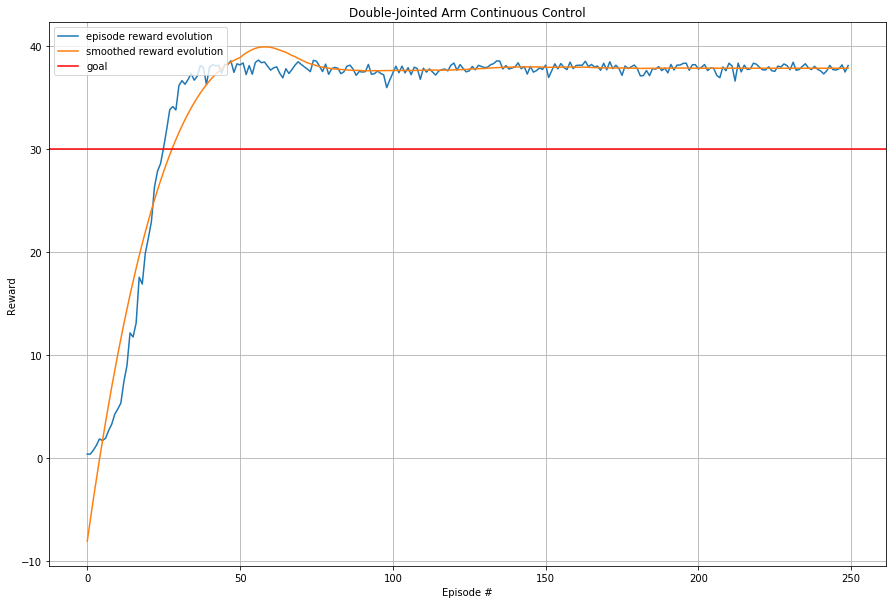

In [13]:
# Plot the reward evolution of the agent during training
agent_trainer.plot_agent_rewards(GOAL_REWARD)

In [14]:
# Close Unity Environment
env.close()

## END
___

Annoyingly, in version 0.4.0 of the ML Unity Environments, it is not possible to launch two environments simultaneously. So to run the single arm evaluation below, you must restart the python kernel and run cells:  
* import
* defintion of PPOActorCriticNetwork
* defintion of hyperparameters

In [ ]:
# Evaluate the learned policy on an episode in the nevironment with a single arm
eval_env = UnityEnvironment(file_name='./Reacher.app')

brain_name = eval_env.brain_names[0]
brain = eval_env.brains[brain_name]
state_dim = brain.vector_observation_space_size
action_dim = brain.vector_action_space_size

In [ ]:
# Reset environment and observe initial states
env_info = eval_env.reset(train_mode=False)[brain_name] 
current_state = env_info.vector_observations[0]

episode_score = 0

# Load trained agent
actor_critic = PPOActorCriticNetwork(state_dim, action_dim, [512, 512])
actor_critic.load_state_dict(torch.load("./double_jointed_arm.pth"))

In [ ]:
# Step through an episode
while True:

    # Take actions as advised by policy
    _, actions, _, _  = actor_critic(current_state)
    env_info = eval_env.step(actions.cpu().detach().numpy())[brain_name]        

    # Observe feedback from environment
    next_state = env_info.vector_observations[0]  
    episode_score += env_info.rewards[0]      
    done = env_info.local_done[0]                 

    # Next time step
    current_state = next_state

    if done:                                    
        # Episode ended
        break

print("Score={:.2f}".format(episode_score))

In [ ]:
# Close Unity Environment
eval_env.close()